<!--NAVIGATION-->
<a href="https://colab.research.google.com/github/masdeseiscaracteres/ml_course/blob/master/exercises/06_boosted_trees.ipynb" target="_parent"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Abrir en Google Colab" title="Abrir y ejecutar en Google Colab"/></a>

# Boosted Trees

Vamos a analizar el funcionamiento de los métodos de Gradient Boosting de `sklearn` mediante ejemplos ilustrativos. 

Contenidos:

1. Un problema de clasificación
2. Un problema de regresión

## 0. Configuración del entorno

In [1]:
# clonar el resto del repositorio si no está disponible
import os
curr_dir = os.getcwd()
if not os.path.exists(os.path.join(curr_dir, '../.ROOT_DIR')):
    !git clone https://github.com/masdeseiscaracteres/ml_course.git ml_course
    os.chdir(os.path.join(curr_dir, 'ml_course/exercises'))

Lo primero es cargar las biblotecas, funciones y datos necesarios.

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

## 1. Un problema de clasificación

Utilizaremos el [Pima Indians Diabetes dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database).

### Ejercicio
Cargue los datos almacenados en el fichero *diabetes.csv*.

### Solución
Cargamos los datos:

In [3]:
data = pd.read_csv('./data/diabetes.csv', sep=',', decimal='.')
print(data.shape)
data.head()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Nos aseguramos de que los tipos de datos son correctos:

In [4]:
data.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

Miramos la frecuencia de cada una de las clases:

In [5]:
data['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

### Análisis exploratorio básico

#### Ejercicio
Represente el histograma de cada variable separando por clases.

#### Solución

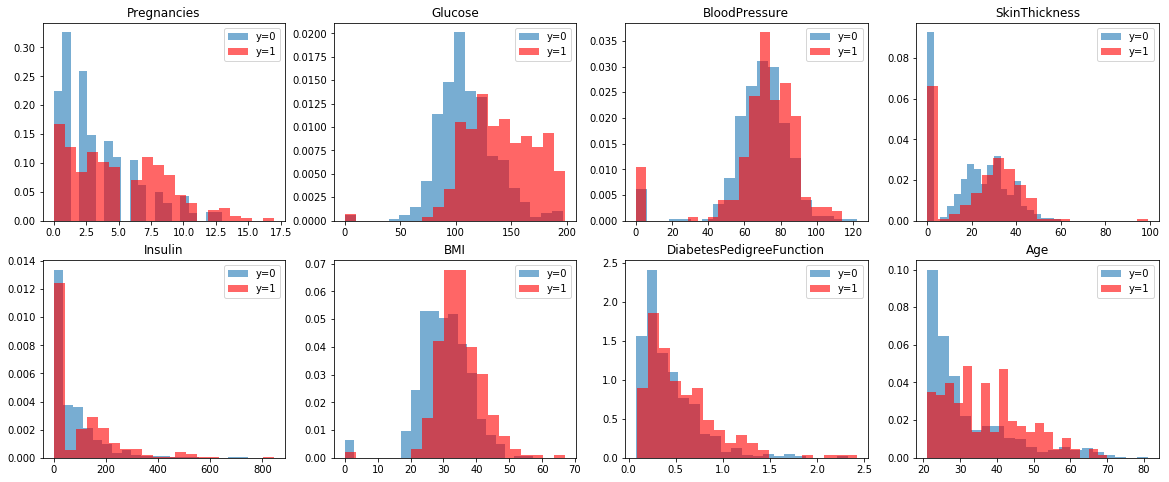

In [6]:
# Pintamos histogramas para cada clase
plt.figure(figsize=(20,8))

idx_0 =  data['Outcome'] == 0
idx_1 =  data['Outcome'] == 1

for i, feature in enumerate(data.columns.drop(['Outcome'])):
    plt.subplot(2, 4, i+1)   
    plt.hist(data.ix[idx_0,feature],density=1, bins=20, alpha=0.6, label='y=0')
    plt.hist(data.ix[idx_1,feature],density=1, bins=20, facecolor='red', alpha=0.6, label='y=1')
    plt.legend()
    plt.title(feature)
plt.show()

#### Ejercicio
A la vista de los histogramas anteriores, ¿cómo de separable crees que es el problema?

#### Solución
Los histogramas para cada una de las clases se solapan considerablemente. Parece que las clases serán más difíciles de separar que en el notebook 05.

### Preparación de los conjuntos de datos
Construyamos nuestro conjunto de test y de entrenamiento simulando una situación real.

In [7]:
from sklearn.model_selection import train_test_split

# preparamos los datos
features = data.columns.drop(['Outcome'])
X = data[features].values
y = data['Outcome'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, shuffle = True, 
                                                    test_size = 0.2, random_state=0)

print('Datos train: ', X_train.shape)
print('Datos test:  ', X_test.shape)

print(np.unique(y_train,return_counts=True))
print(np.unique(y_test, return_counts=True))

Datos train:  (614, 8)
Datos test:   (154, 8)
(array([0, 1]), array([400, 214]))
(array([0, 1]), array([100,  54]))


### Decision trees

Probemos primero con un árbol de decisión sencillo

#### Ejercicio
Entrena un árbol de decisión sencillo, y muestra las prestaciones para el conjunto de test.

#### Solución

best mean cross-validation score: 0.736
best parameters: {'max_depth': 4}


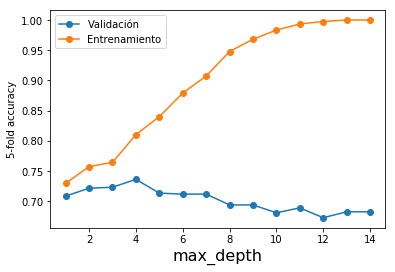

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

max_depth = range(1, 15)
param_grid = {'max_depth': max_depth}

n_folds = 5

clf = DecisionTreeClassifier(random_state=0)
grid = GridSearchCV(clf, param_grid=param_grid, cv=n_folds, return_train_score=True)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores_test = np.array(grid.cv_results_['mean_test_score'])
scores_train = np.array(grid.cv_results_['mean_train_score'])
plt.plot(max_depth, scores_test, '-o', label='Validación')
plt.plot(max_depth, scores_train, '-o', label='Entrenamiento')
plt.xlabel('max_depth', fontsize=16)
plt.ylabel('{}-fold accuracy'.format(n_folds))
plt.legend(loc='best')
plt.show()

In [9]:
best_max_depth = grid.best_params_['max_depth']
tree_model = DecisionTreeClassifier(max_depth=best_max_depth)
tree_model.fit(X_train,y_train)

print("Train: ", tree_model.score(X_train, y_train))
print("Test: ", tree_model.score(X_test, y_test))

Train:  0.7833876221498371
Test:  0.7012987012987013


#### Ejercicio
Representa el árbol entrenado

#### Solución
Pintemos el árbol, a ver qué variables nos salen más relevantes:

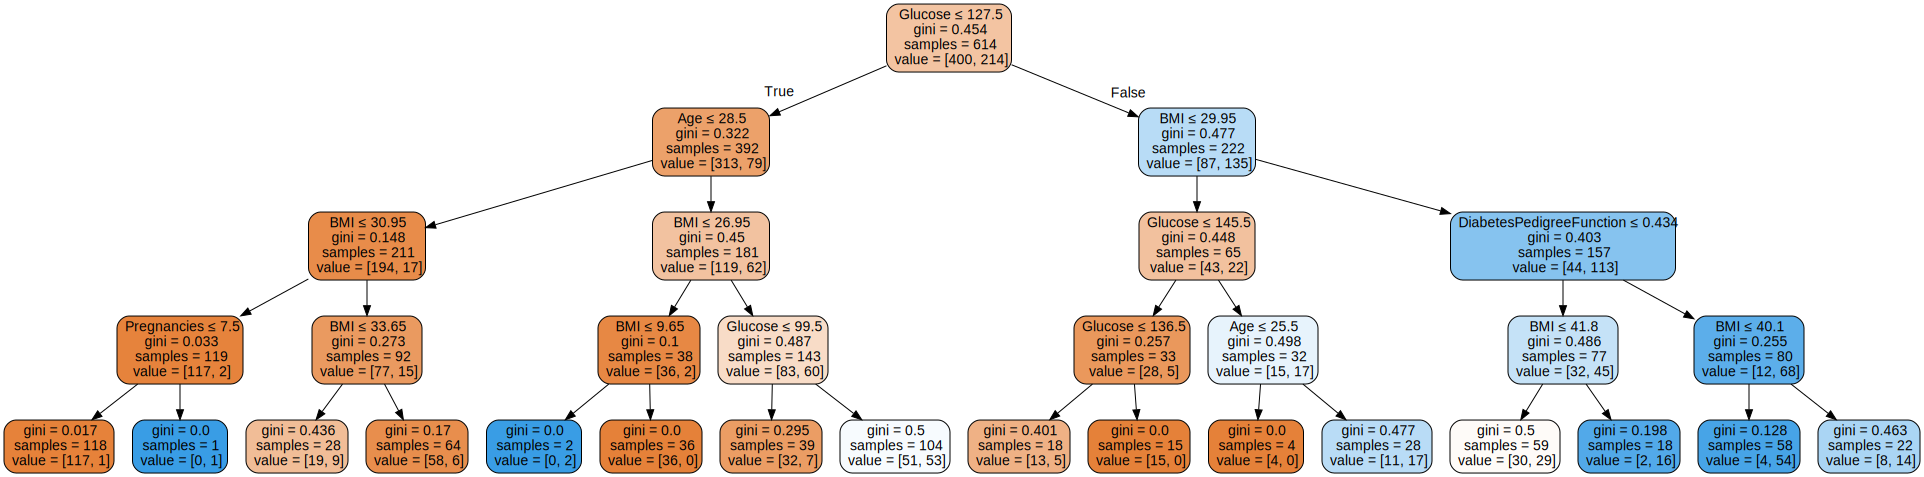

In [10]:
from sklearn.tree import export_graphviz
import graphviz

from sklearn.tree import export_graphviz
import graphviz

tree_dot = export_graphviz(tree_model, out_file=None, feature_names=features,  
                         filled=True, rounded=True,  special_characters=True)
graph = graphviz.Source(tree_dot) 
graph

Parece un problema complicado de clasificar, porque la profundidad del árbol óptima es 2. El algoritmo está bien entrenado porque la diferencia entre train y test es pequeña. Si queremos mejorar prestaciones tendremos que acudir a un modelo más complejo.

### Boosted Trees

El entrenamiento del algoritmo de boosting requiere fijar tres parámetros libres:

- Número de iteraciones.
- Tasa de aprendizaje ($\alpha$).
- Los parámetros propios del árbol: habitualmente su complejidad controlada por el parámetro `max_depth`.

Se podría hacer una búsqueda sobre los tres parámetros conjuntamente mediante `GridSearchCV`, sin embargo, es muy costoso computacionalmente, con lo que es más sencillo aplicar una optimización secuencial: se prueban distintos valores de los parámetros libres, se fijan los óptimos y se busca sobre el resto.

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

Niterations = [25, 50, 75, 100, 125, 150, 175, 200, 300]
learningRate = [0.5, 0.1, 0.05, 0.01]
# max_depth = [2, 3, 4, 5]
# mantenemos max_depth estático: max_depth=2

n_folds = 5

param_grid = {'n_estimators': Niterations, 'learning_rate': learningRate}
clf = GradientBoostingClassifier(random_state=0, max_depth=2)
grid = GridSearchCV(clf, param_grid=param_grid, cv=n_folds)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: 0.761
best parameters: {'learning_rate': 0.01, 'n_estimators': 200}


Representemos el error que estamos cometiendo para los distintos valores de los parámetros libres

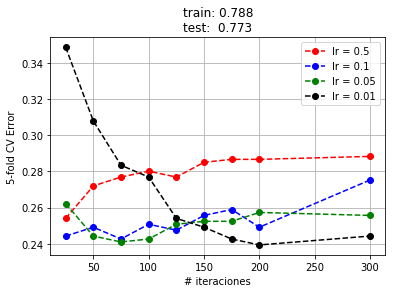

In [12]:
bt = GradientBoostingClassifier(random_state=0, max_depth=2, **grid.best_params_)
bt.fit(X_train, y_train)

error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate), len(Niterations))
colors = ['r', 'b', 'g', 'k', 'm']
for i, lr in enumerate(learningRate):    
    plt.plot(Niterations, error[i,:], colors[i] + '--o', label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('{}-fold CV Error'.format(n_folds))
plt.title('train: %0.3f\ntest:  %0.3f'%(bt.score(X_train, y_train), bt.score(X_test, y_test)))
plt.grid()
plt.show()

Las prestaciones no son mucho mejores que con respecto a un árbol sencillo. Como el coste de entrenamiento de este conjunto no es muy grande, replicaremos el análisis anterior aumentando la complejidad de los árboles.

In [13]:
Niterations = [25, 50, 75, 100, 125, 150, 175, 200, 300]
learningRate = [0.5, 0.1, 0.05, 0.01]
# mantenemos max_depth estático: max_depth=3

n_folds = 5

param_grid = {'n_estimators': Niterations, 'learning_rate': learningRate}
clf = GradientBoostingClassifier(random_state=0, max_depth=n_folds)
grid = GridSearchCV(clf, param_grid=param_grid, cv = 3)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: 0.739
best parameters: {'learning_rate': 0.01, 'n_estimators': 150}


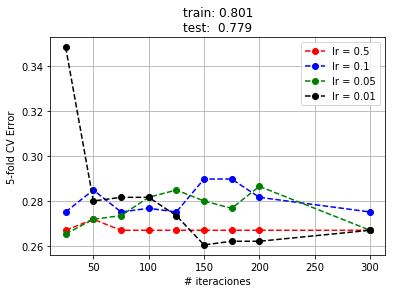

In [14]:
bt = GradientBoostingClassifier(random_state=0, max_depth=3, **grid.best_params_)
bt.fit(X_train, y_train)

error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate), len(Niterations))
colors = ['r', 'b', 'g', 'k', 'm']
for i,lr in enumerate(learningRate):    
    plt.plot(Niterations, error[i,:], colors[i] + '--o', label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('{}-fold CV Error'.format(n_folds))
plt.title('train: %0.3f\ntest:  %0.3f' % (bt.score(X_train, y_train), bt.score(X_test, y_test)))
plt.grid()
plt.show()

En general, cuanto más complejo es el problema, menor es la tasa de aprendizaje requerida y mayor el número de iteraciones que necesita el algoritmo. Parece que podemos ir un poco más allá, disminuyamos un poco más la tasa de aprendizaje.

In [15]:
Niterations = [25, 50, 75, 100, 125, 150, 175, 200, 300]
learningRate = [0.5, 0.1, 0.05, 0.01, 0.005]
# mantenemos max_depth estático: max_depth=3
n_folds = 5

param_grid = {'n_estimators': Niterations, 'learning_rate': learningRate}
clf = GradientBoostingClassifier(random_state=0, max_depth=3)
grid = GridSearchCV(clf, param_grid=param_grid, cv=n_folds)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: 0.757
best parameters: {'learning_rate': 0.05, 'n_estimators': 100}


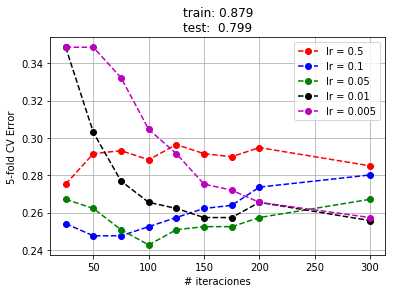

In [16]:
bt = GradientBoostingClassifier(random_state=0, max_depth=3, **grid.best_params_)
bt.fit(X_train, y_train)

error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate), len(Niterations))
colors = ['r', 'b', 'g', 'k', 'm']
for i, lr in enumerate(learningRate):    
    plt.plot(Niterations, error[i,:], colors[i] + '--o', label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('{}-fold CV Error'.format(n_folds))
plt.title('train: %0.3f\ntest:  %0.3f' % (bt.score(X_train, y_train), bt.score(X_test, y_test)))
plt.grid()
plt.show()

#### Ejercicio
Representa la importancia de las variables.

#### Solución

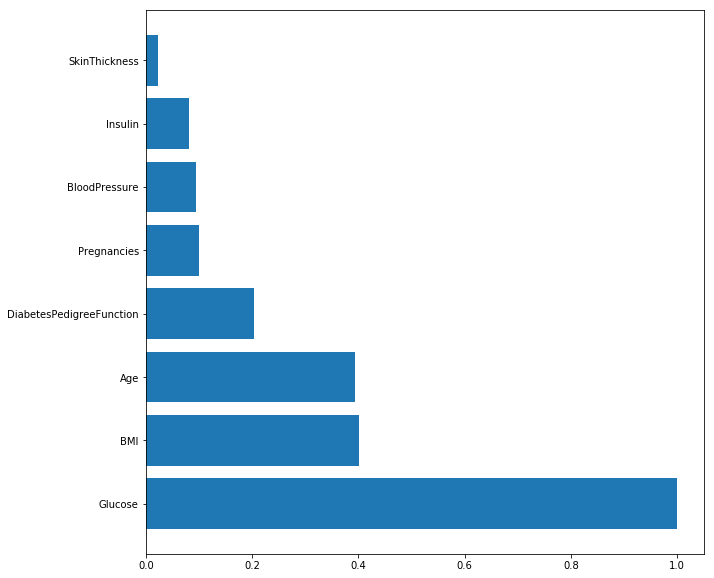

In [17]:
importances = bt.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),features[indices])
plt.show()

Y también podemos representar la dependencia de cada característica con la variable objetivo.

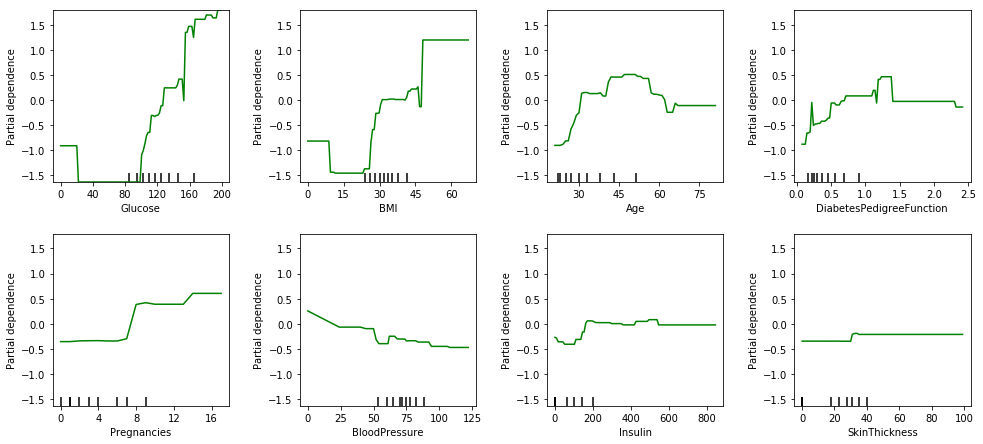

In [18]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence

fig, ax = plot_partial_dependence(bt, X_train, indices, feature_names=features,
                                 percentiles=(0.0, 1.0), n_cols = 4)
fig.set_size_inches(15, 10)
plt.show()

## 2. Un problema de regresión

Cargamos el conjunto de datos `kc_house_data`:

In [19]:
# cargamos datos
house_data = pd.read_csv("./data/kc_house_data.csv") # cargamos fichero

# Eliminamos las columnas id y date 
house_data = house_data.drop(['id','date'], axis=1)

# convertir las variables en pies al cuadrado en metros al cuadrado 
feetFeatures = ['sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15','sqft_lot15']
house_data[feetFeatures] = house_data[feetFeatures].apply(lambda x: x * 0.3048 * 0.3048)

# renombramos
house_data.columns = ['price','bedrooms','bathrooms','sqm_living','sqm_lot','floors','waterfront','view','condition',
                      'grade','sqm_above','sqm_basement','yr_built','yr_renovated','zip_code','lat','long',
                      'sqm_living15','sqm_lot15']

# añadimos las nuevas variables
house_data['years']            = pd.Timestamp('today').year - house_data['yr_built']
#house_data['bedrooms_squared'] = house_data['bedrooms'].apply(lambda x: x**2)
#house_data['bed_bath_rooms']   = house_data['bedrooms']*house_data['bathrooms']
house_data['sqm_living']   = house_data['sqm_living'].apply(lambda x: np.log(x))
house_data['price']        = house_data['price'].apply(lambda x: np.log(x))
#house_data['lat_plus_long']    = house_data['lat']*house_data['long']


# convertimos el DataFrame al formato necesario para scikit-learn
data = house_data.values 

y = data[:,0:1]     # nos quedamos con la 1ª columna, price
X = data[:,1:]      # nos quedamos con el resto

feature_names = house_data.columns[1:]

# Dividimos los datos en entrenamiento y test (80 training, 20 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state = 2)

print('Datos entrenamiento: ', X_train.shape)
print('Datos test: ', X_test.shape)

Datos entrenamiento:  (16209, 19)
Datos test:  (5404, 19)


Dado que el número de muestras del problema es mayor, y para no alargar demasiado el proceso de entrenamiento, escogeremos de forma muy secuencial los parámetros libres.

AVISO: Este proceso puede tardar un rato ...

In [20]:
from sklearn.ensemble import GradientBoostingRegressor

Niterations = [500, 1000, 1500, 2000]
learningRate = [0.1, 0.05]
# mantenemos max_depth estático: max_depth=3

n_folds = 5

param_grid = {'n_estimators': Niterations, 'learning_rate': learningRate}
clf = GradientBoostingRegressor(random_state=0, max_depth=3)
grid = GridSearchCV(clf, param_grid=param_grid, cv=n_folds)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: 0.898
best parameters: {'learning_rate': 0.05, 'n_estimators': 2000}


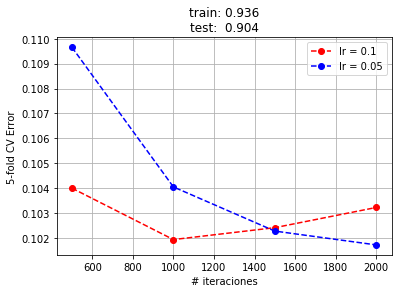

In [21]:
bt = GradientBoostingRegressor(random_state=0, max_depth=3, **grid.best_params_)
bt.fit(X_train, y_train)

error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate), len(Niterations))
colors = ['r', 'b', 'g', 'k', 'm']
for i, lr in enumerate(learningRate):    
    plt.plot(Niterations,error[i,:],colors[i] + '--o', label='lr = %g' % lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('{}-fold CV Error'.format(n_folds))
plt.title('train: %0.3f\ntest:  %0.3f' % (bt.score(X_train, y_train), bt.score(X_test, y_test)))
plt.grid()
plt.show()

### Importancia y dependencia

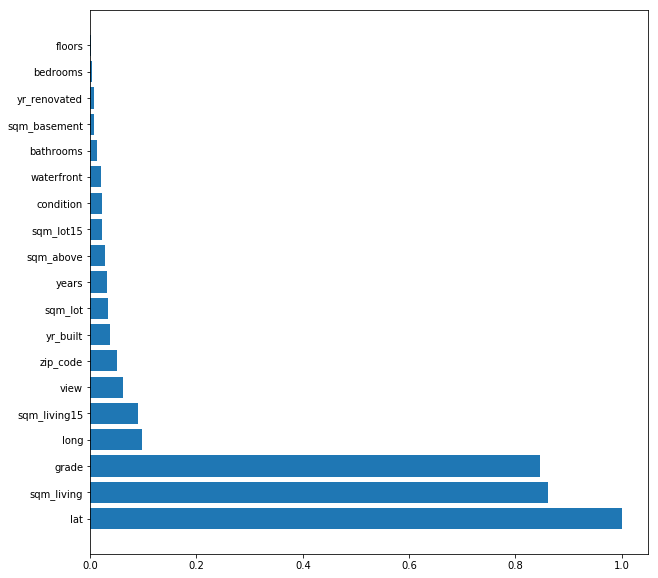

In [22]:
importances = bt.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),feature_names[indices])
plt.show()

Por último, representemos los conocidos como *partial dependence plots*:

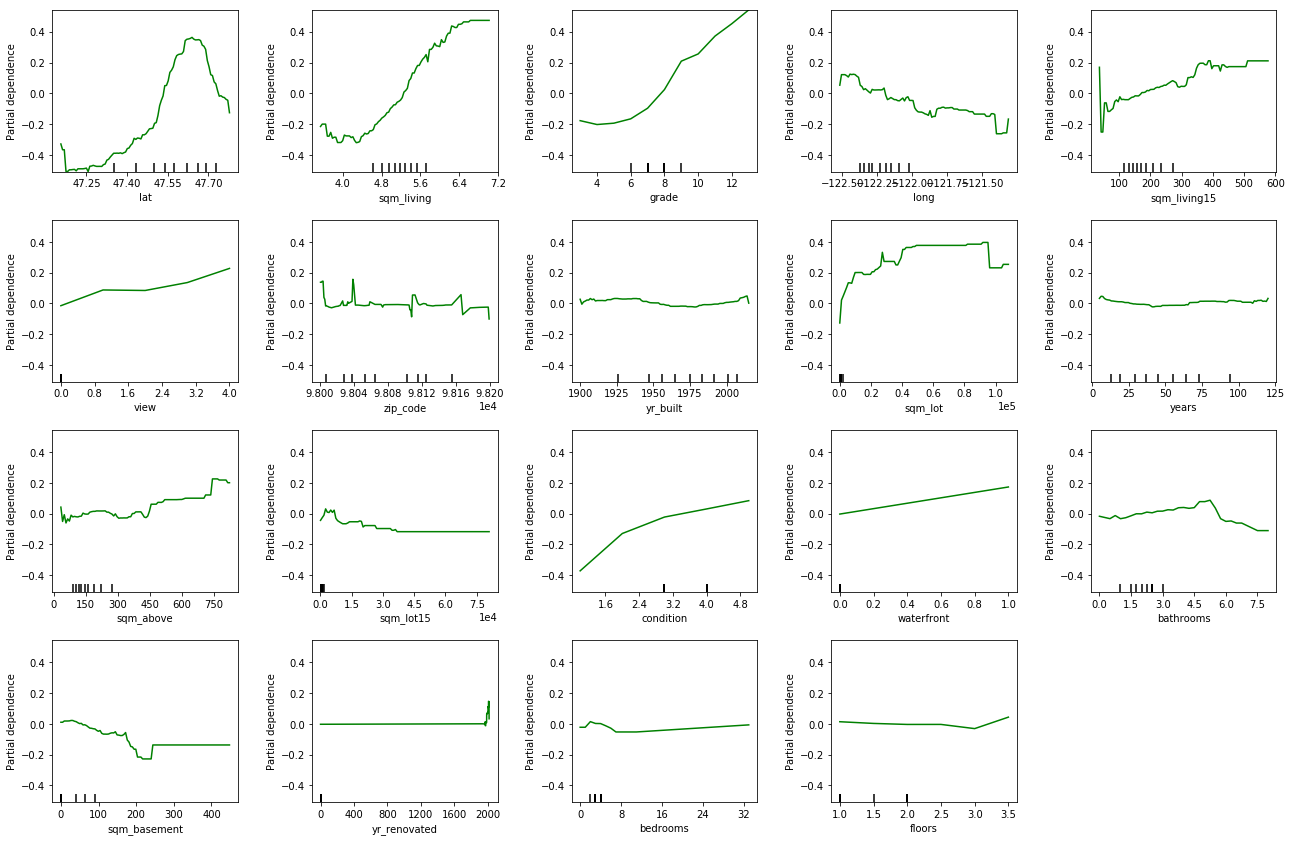

In [23]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence

fig, ax = plot_partial_dependence(bt, X_train, indices, feature_names=feature_names,
                                 percentiles=(0.0, 1.0), n_cols = 5)
fig.set_size_inches(20, 20)
plt.show()

## Siguientes pasos

¿Qué más podríamos hacer? Ajustar con mayor cuidado todos los parámetros que controlan la complejidad de los árboles y el proceso de *boosting*. Esto, seguramente, requeriría mucho tiempo de cómputo y hay que saber elegir adecuadamente cómo hacerlo y los algoritmos a utilizar. Aquí radica el arte del *machine learning*:

1. Utilizar bibliotecas más eficientes de *boosted trees* como [xgBoost](https://xgboost.readthedocs.io/en/latest/), [LightGBM](https://lightgbm.readthedocs.io/en/latest/) o [catBoost](https://catboost.ai/).
2. Conocer la naturaleza del problema (negocio), para generar nuevas *features* relevantes para el objetivo que se busca conseguir.
3. Tratar de buscar más ejemplos.